# Tweet Classification using Word2Vec models and TF-IDF

In [53]:
import pandas as pd
df=pd.read_json(r'H:\Uni Docs\Third Semester\Data Science Lab\Code\Dataset\Final\Final All\migrantPhase3Final_ALL.json', lines="True", orient="records", encoding="utf8")

In [54]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

Preprocessing Stage

In [60]:
#Tokenisation
import re,nltk
from nltk.tokenize import word_tokenize

df['text']=df['text'].apply(lambda row: (re.sub(r'((RT @[^ ]+)|(http[^ ]*)|([—–])|([!”#$%&\’\'\€\✡"\‘()*+\“,-\.\/:;<=>?@[\]^_`{|}~…])|(([^A-Za-z0-9 ])))','', row, flags=re.IGNORECASE)))

df['cleanedtext']=df['text'].apply(lambda row: (re.sub(r'([0-9]+)','c2a0f1s9', row, flags=re.IGNORECASE)))

df['tokenised'] = df['cleanedtext'].apply(lambda row: nltk.word_tokenize(row.lower()))   

#len(df['tokenised'])
#df['tokenised'].value_counts()

In [ ]:
#Stopwords Removal
from nltk.corpus import stopwords
stop = stopwords.words('english')
'theyre', 'thats', 'its'
stop.append('theyre')
stop.append('thats')
stop.append('its')
df['stopwords']=df['tokenised'].apply(lambda x: [item for item in x if item not in stop])


In [ ]:
#Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df['stemmed']=df.apply(lambda row: [ps.stem(word) for word in row['tokenised']], axis=1) 


In [ ]:
X = df['stemmed']
y = df['label']

Feature Extraction

In [ ]:
#Building a Word2Vec model
import gensim
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = gensim.models.Word2Vec(X, size=10, window=5, min_count=1, workers=2)
#model.train(X,total_examples=len(X),epochs=5)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}
#print(w2v)
#print((model.wv.syn0[10]))
words=list(model.wv.vocab)
print('Vocabulary size:%d' % len(words))
#vocab_obj = w2v.vocab["word"]
#vocab_obj.count
model.wv.most_similar('migrant')
#w2v.items()

In [68]:
#Method for TFIDF Word2Vec Model
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [71]:
#Method For Word2Vec Model that uses mean as aggregation function
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        for words in X:
            print (np.array([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)]))
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
            
    #def fit_transform(self, X, y=None):
        #return self.fit(X, y).transform(X)

In [29]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
#mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
#bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
#mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
#bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
#svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
#percept =  Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("Percept", Perceptron(max_iter=5))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
percept_tfidf =  Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("Percept_tfidf", Perceptron(max_iter=5))])
etree_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("etree_tfidf", ExtraTreesClassifier(n_estimators=200))])
sgdc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("sgdc_tfidf", SGDClassifier())])
rand_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("rand_tfidf", RandomForestClassifier())])

In [30]:
etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("etree_w2v", ExtraTreesClassifier(n_estimators=200))])

svc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("svc_w2v", SVC(kernel="linear"))])

percept_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("percept_w2v", Perceptron(max_iter=5))])

sgdc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("sgdc_w2v", SGDClassifier())])

rand_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("rand_w2v", RandomForestClassifier())])


In [31]:
etree_combo = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("etree_combo", ExtraTreesClassifier(n_estimators=200))])

svc_combo = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("svc_combo", SVC(kernel="linear"))])

percept_combo = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("percept_combo", Perceptron(max_iter=5))])

sgdc_combo = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("sgdc_combo", SGDClassifier())])

rand_combo = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("rand_combo", RandomForestClassifier())])

In [32]:
all_models = [
    ("svc_tfidf", svc_tfidf),
    ("etree_tfidf", etree_tfidf),
    ("Percept_tfidf", percept_tfidf),
    #("sgdc_tfidf",sgdc_tfidf),
    ("rand_tfidf",rand_tfidf),
    ("etree_w2v", etree_w2v),
    ("svc_w2v",  svc_w2v),
    ("percept_w2v",percept_w2v),
    #("sgdc_w2v",sgdc_w2v),
    ("rand_w2v",rand_w2v),
    #("etree_combo", etree_combo),
    #("svc_combo",  svc_combo),
    #("percept_combo",percept_combo),
    #("sgdc_combo",sgdc_combo),
    #("rand_combo",rand_combo),
]

Evaluation

In [ ]:
result_accuracy = [(name, cross_val_score(model, X, y,scoring='accuracy', cv=10).mean()) for name, model in all_models]
result_precision =[(name, cross_val_score(model, X, y,scoring='precision', cv=10).mean()) for name, model in all_models]
result_recall = [(name, cross_val_score(model, X, y,scoring='recall', cv=10).mean()) for name, model in all_models]
result_f1 = [(name, cross_val_score(model, X, y,scoring='f1', cv=10).mean()) for name, model in all_models]

print (tabulate(result_accuracy, floatfmt=".4f", headers=("model", 'accuracy')))
print (tabulate(result_precision, floatfmt=".4f", headers=("model", 'precision')))
print (tabulate(result_recall, floatfmt=".4f", headers=("model", 'recall')))
print (tabulate(result_f1, floatfmt=".4f", headers=("model", 'float')))

In [ ]:
classifier=VotingClassifier(estimators=[    ("svc_tfidf", svc_tfidf),
    ("etree_tfidf", etree_tfidf),
    ("Percept_tfidf", percept_tfidf),
    #("sgdc_tfidf",sgdc_tfidf),
    ("rand_tfidf",rand_tfidf),
    ("etree_w2v", etree_w2v),
    ("svc_w2v",  svc_w2v),
    #("percept_w2v",percept_w2v),
    #("sgdc_w2v",sgdc_w2v),
    ("rand_w2v",rand_w2v),
    ("etree_combo", etree_combo),
    ("svc_combo",  svc_combo),
    #("percept_combo",percept_combo),
    #("sgdc_combo",sgdc_combo),
    #("rand_combo",rand_combo),], voting='hard')
result_accuracy = cross_val_score(classifier, X, y, scoring='accuracy', cv=10)
result_precision = cross_val_score(classifier, X, y, scoring='precision', cv=10)
result_recall = cross_val_score(classifier, X, y, scoring='recall', cv=10)
result_f1 = cross_val_score(classifier, X, y, scoring='f1', cv=10)

print(result_accuracy.mean())
print(result_precision.mean())
print(result_recall.mean())
print(result_f1.mean())

In [ ]:
unsorted_scores = [(name, cross_val_score(model, X, y,scoring='accuracy', cv=10).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

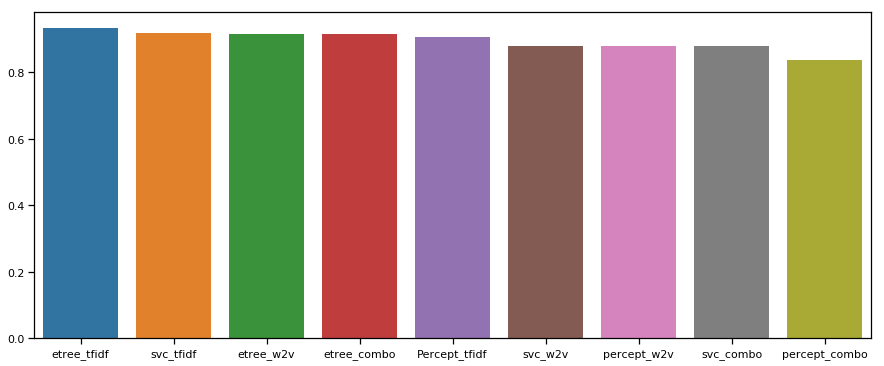

In [362]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

In [481]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=10, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(f1_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [ ]:
train_sizes = [10,40,160,640,1000,1400,2500]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'f1': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)
df

[Text(0,0.5,'accuracy')]

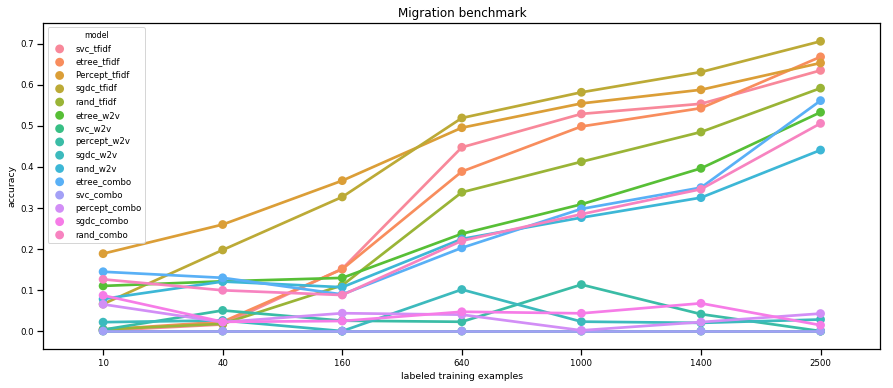

In [483]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='f1', hue='model', 
                    data=df[df.model.map(lambda x: x in ["svc_tfidf",
                                                         "etree_tfidf",
                                                         "Percept_tfidf",
                                                         "sgdc_tfidf",
                                                         "rand_tfidf",
                                                         "etree_w2v",
                                                         "svc_w2v",
                                                         "percept_w2v",
                                                         "sgdc_w2v",
                                                         "rand_w2v",
                                                         "etree_combo",
                                                         "svc_combo",
                                                         "percept_combo",
                                                         "sgdc_combo",
                                                         "rand_combo"
                                                        ])])

sns.set_context("notebook", font_scale=1)
fig.set(ylabel="f1")
fig.set(xlabel="labeled training examples")
fig.set(title="Migration benchmark")
fig.set(ylabel="accuracy")